In [1]:
import numpy as np
import pandas as pd
import novosparc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
data_path = 'raw/expr_matrix_10day_log_normalized.txt'   # 11566 cells and 2000 genes
output_folder = 'out'
tissue_path = 'raw/myshape.npy'
hvg_path = 'raw/high_variable_genes_10day.txt'
location_marker = 'raw/dge_full.txt'

In [3]:
# load dataset:  expression matrix   col-gene,row-cell
dataset = novosparc.io.load_data(data_path)

In [4]:
dataset.shape

(11566, 30230)

In [5]:
# just to view gene names and the matrix
gene_names = np.asarray(dataset.var.index.tolist())

In [6]:
# ### set average gene expr close to 1
# ### not sure about its impact, but perhaps it could get things closer to marker's binary value????

# my = dataset.X
# for i in range(my.shape[0]):
#     divide_by = np.average(my[i][my[i]>0])
#     my[i] = my[i]/divide_by+0.00000001   
# dataset.X = my

In [7]:
# save the set to dataset.raw
dataset.raw = dataset
# select only genes in hvg_list
dataset, hvg = novosparc.pp.subset_to_hvg(dataset, hvg_file = hvg_path) # dataset[:,dataset.var.index.isin(gene_list)], gene_list

In [8]:
# downsample data --- current hvg list is not correct
cells_selected, dataset = novosparc.pp.subsample_dataset(dataset, min_num_cells=3000, max_num_cells=3100)

In [9]:
dataset.shape

(3025, 2000)

In [10]:
print(np.max(dataset.X),np.min(dataset.X),np.average(dataset.X))

8.524791 0.0 0.055395037


### load target space (location)

In [11]:
# load target space
# locations = novosparc.geometry.create_target_space_from_image(tissue_path) #

locations = np.load(tissue_path)
locations.shape

(66203, 2)

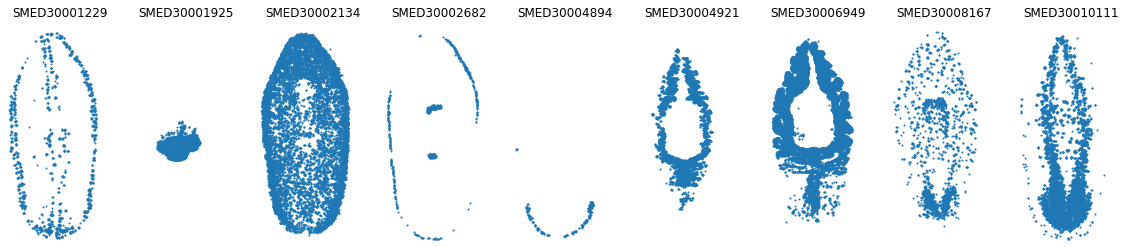

In [12]:
# just to check if atlas is correct
atlas_path = 'raw/atlas.txt'
insitu_genes = np.genfromtxt(atlas_path, usecols=range(29), dtype='str', max_rows=1)
plt.figure(figsize=(20,4))
for i in range(9):
    myimg = np.load('chk/{}.npy'.format(insitu_genes[i].split('.')[0]))
    myloc = locations[myimg==1]
    plt.subplot(1,9,i+1)
    plt.scatter(myloc[:, 0], myloc[:, 1],s=1)
    plt.title(insitu_genes[i])
    plt.xlim(0,200)
    plt.ylim(0,500)
    plt.axis('off')
plt.show()    

In [13]:
# subsample the locations to save effort -- low resolution now
cell_nb = dataset.shape[0]
seed = np.random.choice(locations.shape[0], cell_nb)  ### -------- later to select markers   3000  11566  cell_nb
locations = locations[seed, :]
locations.shape

(3025, 2)

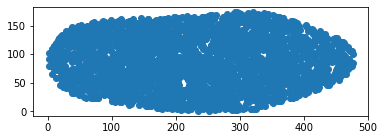

In [14]:
plt.figure(figsize=(6,2))
plt.scatter(locations[:, 1], locations[:, 0])
plt.show()

### Reconstruction
https://github.com/rajewsky-lab/novosparc/blob/master/reconstruct_drosophila_embryo_tutorial.ipynb

In [15]:
#Reconstruct the tissue de novo/with marker
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations, output_folder=output_folder)

In [16]:
atlas_path = 'raw/atlas.txt'
insitu_genes = np.genfromtxt(atlas_path, usecols=range(29), dtype='str', max_rows=1)

In [17]:
# find indices of marker genes in dge dataset
gene_names = tissue.gene_names
markers_in_sc = np.array([], dtype='int')
markers_in_sc_name = []
for marker in insitu_genes:
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])
        markers_in_sc_name.append(marker)

In [18]:
# load atlas matrix
# make sure atlas_matrix.shape[1]==tissue.dge[:, markers_in_sc].shape[1] (or dataset.dge)
# also don't forget to extract points that used in locations only  (seed)
atlas_matrix = pd.read_csv(atlas_path,sep='\t')
atlas_matrix = atlas_matrix[markers_in_sc_name]
atlas_matrix = atlas_matrix.to_numpy()
atlas_matrix = atlas_matrix[seed,:]
atlas_matrix.shape

(3025, 23)

In [19]:
np.unique(atlas_matrix)

array([0, 1], dtype=int64)

In [20]:
tissue.setup_reconstruction(markers_to_use=markers_in_sc, insitu_matrix=atlas_matrix, num_neighbors_s=10, num_neighbors_t=10)

Setting up for reconstruction ... done ( 34.9 seconds )


##### set alpha_linear

In [21]:
tissue.reconstruct(alpha_linear=0.9, epsilon=5e-3) ########调试alpha_linear，似乎是marker gene 的重要程度[0-1]，0是不加marker

Reconstructing spatial information with 23 markers: 3025 cells and 3025 locations ... 
It.  |Err         
-------------------
    0|1.656168e-03|


In [22]:
import time
t1 = time.time()
tissue.calculate_spatially_informative_genes()
t2 = time.time()
print(t2-t1)

Setting up Morans I analysis for 2000 genes...

c:\users\jiarong\appdata\local\programs\python\python37\lib\site-packages\novosparc\analysis\_analysis.py:71: RuntimeWarning: invalid value encountered in true_divide
  expression = (sdge.T / np.sum(sdge, axis=1))


done ( 164.66 seconds )
164.75229024887085


### show result

In [23]:
sdge_hvg = tissue.sdge

In [24]:
sdge = tissue.calculate_sdge_for_all_genes()
sdge.shape

(30230, 3025)

In [25]:
np.max(sdge)

0.0029048942267906894

In [26]:
# # plot some genes
# gene_list_to_plot = [
#     'SMED30011970', #eye and head, dd_4427
#     'SMED30030642', #pharynx
#     'SMED30001882',#brain and phx
#     'SMED30005457', #super strong; big cells around the gut
#     'SMED30000013', #gut
#     'SMED30010123', #protonephridia
#     'SMED30016244', #secretory cells?
#     'SMED30011490' #epithelium
# ]
gene_list_to_plot = [
    'SMED30001925',
    'SMED30002134',
    'SMED30002682',
    'SMED30004921',
]

In [27]:
gene_dict = {
    'SMED30011970':'eye and head',
    'SMED30030642':'pharynx',
    'SMED30001882':'brain and phx',
    'SMED30005457':'big cells-gut(++)',
    'SMED30000013':'gut',
    'SMED30010123':'protonephridia',
    'SMED30016244':'secretory cells',
    'SMED30011490':'epithelium',
    'SMED30004921':'SMED30004921',
    'SMED30001925':'SMED30001925',
    'SMED30002134':'SMED30002134',
    'SMED30002682':'SMED30002682',
}


In [28]:
sum(tissue.gene_names=='SMED30001229')

0

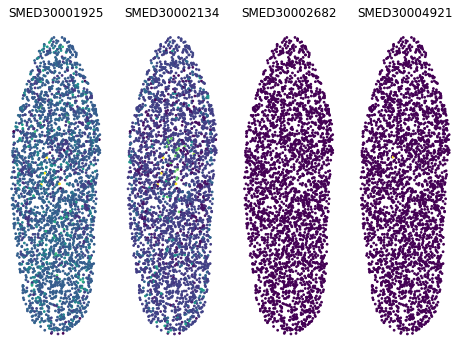

In [29]:
mylen=len(gene_list_to_plot)
plt.figure(figsize=(2*mylen,6))

for i in range(len(gene_list_to_plot)):
        plt.subplot(1,mylen,i+1)        
        expr_val = sdge[np.argwhere(gene_names == gene_list_to_plot[i])[0], :].flatten()        

        plt.scatter(locations[:, 0], locations[:, 1], c=expr_val, s=3)
        plt.title(gene_dict[gene_list_to_plot[i]])
        plt.axis('off')
plt.show()

In [30]:
sum(expr_val)

0.000659171401961774